files in ~/Library/Mobile Documents/com~apple~CloudDocs/Conferences/2023/Ferrarra/babel

In [1]:
# Required for data handling and manipulation
import pandas as pd
import numpy as np
# TensorFlow and tf.keras for neural networks or deep learning
import tensorflow as tf
from tensorflow import keras

# Let's verify the TensorFlow version while we are at it
print(tf.__version__)


2.4.3


In [4]:
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

In [2]:
# Replace 'file_path' with the path to your .csv.gz file
df = pd.read_csv('~/data/TRD/results/shiny/YJNRC18-AF.csv.gz', compression='gzip')

# Let's take a look at the first few rows of the DataFrame
print(df.head())


           chr    pos alleles  GT1  GT2  ADcross  DPcross  AD3_0  AD3_1  \
0  chromosome1  27781     C,T  0/0  1|1    68,86      154     68     86   
1  chromosome1  27783     A,G  0/0  1|1    68,89      157     68     89   
2  chromosome1  27882     G,T  0/0  1/1  134,145      279    134    145   
3  chromosome1  27892     G,A  1/1  0/0  148,128      276    148    128   
4  chromosome1  27914     T,C  0/0  1/1  129,143      272    129    143   

   AD3_2  AD3_3  Allele1  Allele2  AD_A1  AD_A2  global_pos  sumCount  \
0    NaN    NaN        0        1     68     86       27781       154   
1    NaN    NaN        0        1     68     89       27783       157   
2    NaN    NaN        0        1    134    145       27882       279   
3    NaN    NaN        1        0    128    148       27892       276   
4    NaN    NaN        0        1    129    143       27914       272   

   smoothed       lwr       upr  
0  0.477671  0.468844  0.486497  
1  0.477671  0.468845  0.486497  
2  0.477

In [5]:
AF = df["AD_A1"] / df["sumCount"]
AF

0        0.441558
1        0.433121
2        0.480287
3        0.463768
4        0.474265
           ...   
38057    0.493392
38058    0.483193
38059    0.458150
38060    0.506550
38061    0.567839
Length: 38062, dtype: float64

In [6]:
np.max(AF)

0.939622641509434

In [320]:
import pandas as pd

def smooth_data(data, window_size):
    series = pd.Series(data)
    series = series.rolling(window_size).mean().to_numpy()
    if window_size>0:
        series[0:(window_size-1)]=smooth_data(data[0:(window_size-1)],window_size-1)
    return series



AF_smooth=smooth_data(AF, 10)

In [321]:
np.max(AF_smooth)

0.921826474247178

In [322]:
#training_mean = AF_smooth.mean()
#training_std = AF_smooth.std()
#AF_normalized = (AF_smooth - training_mean) / training_std

In [323]:
import numpy as np
# Tensorflow laden
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [324]:
window_size=1000
step=1000
big_step=100
consecutive_windows=10

def create_windows(data, window_size, step, big_step, consecutive_windows):
    nested_list = []
    i = 0
    while i < len(data) - window_size + 1:
        start = i
        for _ in range(consecutive_windows):
            if i < len(data) - window_size + 1:
                nested_list.append(data[i:i+window_size])
                i += step
        i = start + big_step
    return nested_list

nested_list = create_windows(AF_smooth, window_size, step, big_step, consecutive_windows)




nested_list=np.array(nested_list)
std_list=list()
avg_list=list()

for i in range(len(nested_list)):
    training_mean = nested_list[i].mean()
    training_std = nested_list[i].std()
    std_list.append(training_std)
    avg_list.append(training_mean)
    if training_std != 0:
        nested_list[i] = (nested_list[i] - training_mean) / training_std
    else:
        nested_list[i] = np.zeros_like(nested_list[i])



# Define some constants
latent_size = 5  # size of the encoded representations
pooling_size = 10
num_filters = 20  # number of convolutional filters
kernel_size = 50  # size of the convolutional filters
dense_units = latent_size*16  # number of units in the dense layers
dropout_rate = 0.2  # dropout rate

new_window_size=int(window_size * num_filters)  # Adjusted window size after pooling

encoder = keras.Sequential([
    
    # Reshape the input to add an extra dimension
    layers.Reshape((window_size, 1)),  
    
    #layers.AveragePooling1D(pooling_size), # reduce noise

    # Conv1D layer with `num_filters` filters, each of size `kernel_size`
    layers.Conv1D(num_filters, kernel_size = kernel_size, activation = "relu"),  

    # Flatten layer to reshape the 3D output to 2D
    layers.Flatten(),

    # Dense layer with `dense_units` units
    layers.Dense(dense_units, activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/2), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/4), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/8), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `latent_size` units
    layers.Dense(latent_size)
])

decoder = keras.Sequential([
    # Input layer expecting a 1D input of size `latent_size`
    keras.Input(shape=(latent_size,)),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/8), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/4), activation = "relu"),
    
     # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/2), activation="relu"),
    
     # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `dense_units` units
    layers.Dense(dense_units, activation="relu"),

    # Dense layer with `window_size * num_filters` units
    layers.Dense(window_size * num_filters, activation="relu"),

    # Reshape layer to get ready for a Conv1DTranspose layer
    layers.Reshape((new_window_size,)),  # Adjusted window size after pooling

    # Flatten layer to prepare for the final Dense layer
    layers.Flatten(),
    
    # Final Dense layer with `window_size` units
    layers.Dense(window_size, activation="linear")
])



start = keras.Input(shape = (window_size,))
latent_vector = encoder(start)
output = decoder(latent_vector)

model = keras.Model(inputs = start, outputs = output)
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
    loss = keras.losses.MeanSquaredError(),
    metrics = [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanAbsolutePercentageError()
    ]
)

EPOCHS = 10

model.fit(nested_list, nested_list, epochs = EPOCHS, batch_size=1)

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
model.save('XX_TryToUseMLForSignals.keras')

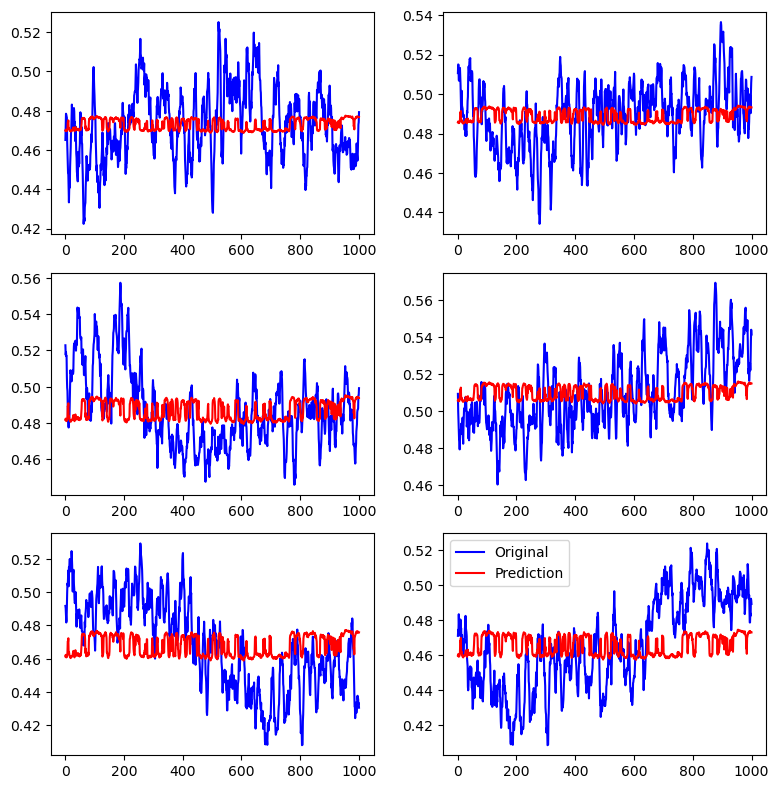

In [325]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 5x4 subplots

# Reshape axs for easier iteration
axs = axs.reshape(-1)

x = 1  # number of consecutive nested_list items to take in each iteration
step = 1000  # step size between each item

for i, ax in enumerate(axs):
    # Choose the starting index such that enough consecutive items can be taken
    start_idx = np.random.randint(0, len(nested_list) - (x-1)*step)
    idxs = [start_idx + j*step for j in range(x)]  # indices of the items to be taken

    # Concatenate samples and predictions from each index
    samples = []
    predictions = []
    for idx in idxs:
        sample = nested_list[idx]
        sample = sample[np.newaxis, :]  # Add an extra dimension for batch_size
        prediction = model.predict(sample, verbose=0)

        # Remove extra dimensions for visualization
        sample = sample[0]*std_list[idx]
        prediction = prediction[0]*std_list[idx]
        
        sample=sample+avg_list[idx]
        prediction=prediction+avg_list[idx]

        samples.append(sample)
        predictions.append(prediction)

    # Concatenate along the time axis (axis=0)
    samples = np.concatenate(samples, axis=0)
    predictions = np.concatenate(predictions, axis=0)

    # Plot the original data in blue
    ax.plot(range(1, len(samples) + 1), samples, color='blue', label='Original')

    # Plot the model's prediction in red
    ax.plot(range(1, len(predictions) + 1), predictions, color='red', label='Prediction')

    # If you want legends on all subplots uncomment below line
    # ax.legend()

# Show legends for the last subplot
axs[-1].legend()

plt.tight_layout()
plt.show()


What I can do now is I can cluster the latent variables for each position and then use those clusters to detect clusters / autoencode consecutive clusters and then see if those correspond to TRD loci

In [326]:
df=pd.DataFrame()
df["X"]=range(1,1001)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


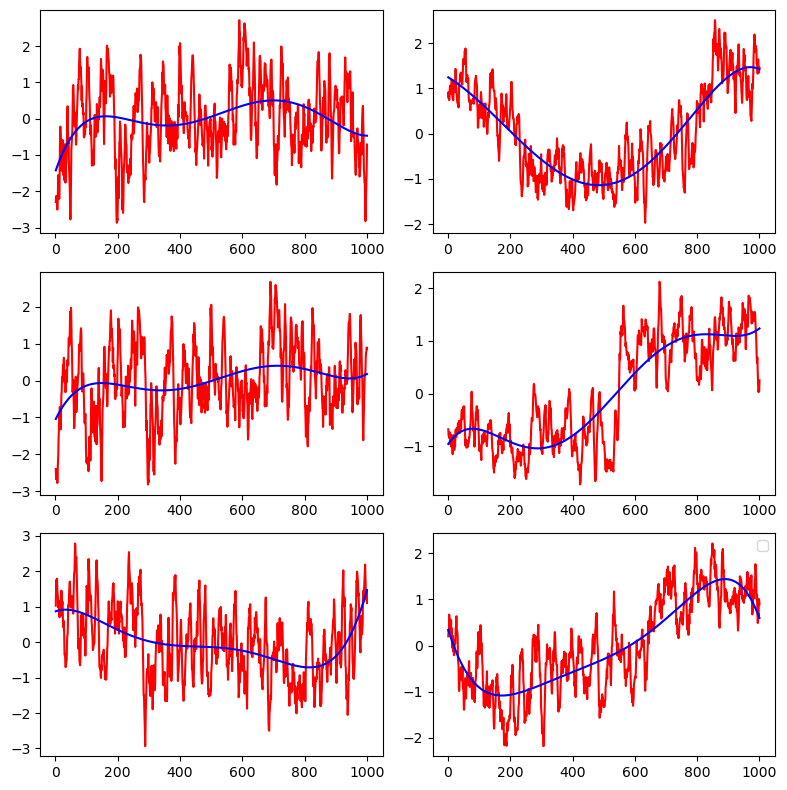

In [327]:
# use polynomial model instead
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 5x4 subplots
axs = axs.reshape(-1)



from sklearn.preprocessing import PolynomialFeatures

for i, ax in enumerate(axs):

    ix=np.random.randint(0, len(nested_list))

    poly_reg = PolynomialFeatures(degree=5)
    X_poly = poly_reg.fit_transform(df[["X"]])
    lin_reg2 = LinearRegression()
    lin_reg2.fit(X_poly,nested_list[ix])

    X_grid = np.arange(min(df["X"]),max(df["X"]),0.1)
    X_grid = X_grid.reshape(len(X_grid),1) 
    ax.plot(df["X"],nested_list[ix], color='red') 

    ax.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

axs[-1].legend()

plt.tight_layout()
plt.show()


In [328]:
# get coefficients throughout

poly_coef_df=pd.DataFrame(columns=["window","intercept","poly1","poly2","poly3","poly4","poly5"])
poly_coef_df["window"]=range(0,len(nested_list))

for ix in range(0,len(nested_list)):
    poly_reg = PolynomialFeatures(degree=5)
    X_poly = poly_reg.fit_transform(df[["X"]])
    lin_reg2 = LinearRegression()
    lin_reg2.fit(X_poly,nested_list[ix])
    poly_coef_df.loc[ix] = np.insert(lin_reg2.coef_,0,ix)

In [329]:
from sklearn.preprocessing import StandardScaler



In [330]:
poly_coef_df_important_data = poly_coef_df.iloc[:, 2:]

scalers = {}
poly_coef_df_important_scaled = poly_coef_df_important_data.copy()
for column in poly_coef_df_important_data.columns:
    scaler = StandardScaler()
    poly_coef_df_important_scaled[column] = scaler.fit_transform(poly_coef_df_important_data[column].values.reshape(-1,1))
    scalers[column] = scaler

window_size=10
num_features=5
step=1

def create_windows(data, window_size, step):
    windows = np.empty((len(data) - window_size + 1, window_size, data.shape[1])) # Initializing an empty array
    for i in range(len(data) - window_size + 1):
        windows[i] = data[i:i+window_size]
    return windows


poly_coef_windows = create_windows(poly_coef_df_important_scaled.to_numpy(), window_size, step)
poly_coef_windows = np.array(poly_coef_windows)



# Define some constants
latent_size = 20  # size of the encoded representations
num_filters = 200  # number of convolutional filters
kernel_size = 3  # size of the convolutional filters
dense_units = 50  # number of units in the dense layers
dropout_rate = 0.2  # dropout rate

new_window_size=int(window_size * num_filters)  # Adjusted window size after pooling

encoder = keras.Sequential([
    
    layers.Reshape((window_size, num_features, 1)),  # add this line
    layers.Conv2D(num_filters, kernel_size=(kernel_size, kernel_size), activation="relu", padding='same'),
 
    layers.Flatten(),

    # Dense layer with `dense_units` units
    layers.Dense(dense_units, activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `latent_size` units
    layers.Dense(latent_size)
])

decoder = keras.Sequential([
    # Input layer expecting a 1D input of size `latent_size`
    keras.Input(shape=(latent_size,)),

    
    

    # Dense layer with `dense_units` units
    layers.Dense(dense_units, activation="relu"),
    
     # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `window_size * num_filters` units
    layers.Dense(window_size * num_filters, activation="relu"),
    
    # Final Dense layer adjusted to match input data shape
    layers.Dense(window_size * 5, activation="linear"),

    # Reshape the output to match the shape of your input data
    layers.Reshape((window_size, num_features)),  # change this line
])



start = keras.Input(shape = (window_size, num_features, 1))  # Adjusted to match the actual input shape
latent_vector = encoder(start)
output = decoder(latent_vector)

model = keras.Model(inputs = start, outputs = output)
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
    loss = keras.losses.MeanAbsoluteError(),
    metrics = [
        keras.metrics.MeanSquaredError(),
        keras.metrics.MeanAbsolutePercentageError()
    ]
)

EPOCHS = 10

# Reshape to add a channel dimension
poly_coef_windows = poly_coef_windows.reshape((-1, window_size, num_features, 1))

model.fit(poly_coef_windows, poly_coef_windows, epochs = EPOCHS, batch_size=1)

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = keras.losses.MeanAbsoluteError(),
    metrics = [
        keras.metrics.MeanSquaredError(),
        keras.metrics.MeanAbsolutePercentageError()
    ]
)


model.fit(poly_coef_windows, poly_coef_windows, epochs = EPOCHS, batch_size=1)


Epoch 1/10
3251/3251 [==============================] - 13s 4ms/step - loss: 0.6411 - mean_squared_error: 0.6904 - mean_absolute_percentage_error: 355.4226
Epoch 2/10
3251/3251 [==============================] - 12s 4ms/step - loss: 0.5010 - mean_squared_error: 0.4375 - mean_absolute_percentage_error: 366.0447
Epoch 3/10
3251/3251 [==============================] - 12s 4ms/step - loss: 0.4742 - mean_squared_error: 0.4047 - mean_absolute_percentage_error: 356.3312
Epoch 4/10
3251/3251 [==============================] - 12s 4ms/step - loss: 0.4566 - mean_squared_error: 0.3847 - mean_absolute_percentage_error: 327.7668
Epoch 5/10
3251/3251 [==============================] - 14s 4ms/step - loss: 0.4414 - mean_squared_error: 0.3644 - mean_absolute_percentage_error: 304.7227
Epoch 6/10
3251/3251 [==============================] - 13s 4ms/step - loss: 0.4376 - mean_squared_error: 0.3652 - mean_absolute_percentage_error: 311.8650
Epoch 7/10
3251/3251 [==============================] - 13s 4ms/

In [331]:
class MyPolynomialModel:
    def __init__(self, degree, coefs):
        self.poly = PolynomialFeatures(degree)
        self.coefs = coefs

    def predict(self, X):
        # Apply polynomial transformation
        X_poly = self.poly.fit_transform(X)
        
        # Apply linear model
        y_pred = np.dot(X_poly, self.coefs)
        return y_pred


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


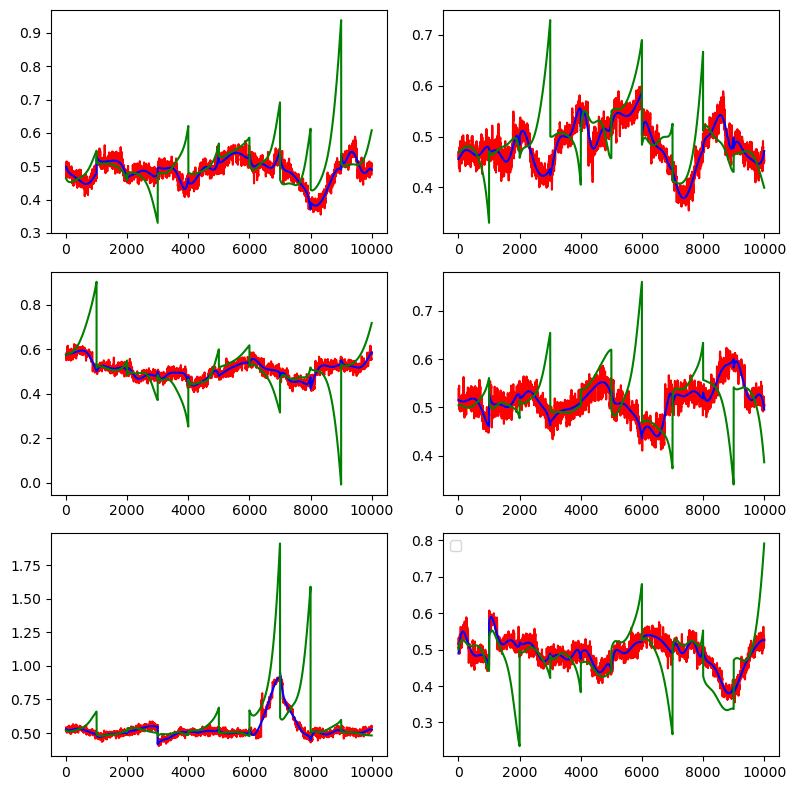

In [ ]:

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 5x4 subplots
axs = axs.reshape(-1)



from sklearn.preprocessing import PolynomialFeatures

for i, ax in enumerate(axs):

    ix=np.random.randint(0, len(nested_list)-10)
    
    sample=poly_coef_windows[ix].reshape(1,10,5)

    prediction = model.predict(sample, verbose=0)[0]
    # Assume column_names is a list of column names in order
    column_names = poly_coef_df_important_data.columns

    prediction_unscaled = np.empty_like(prediction)

    for i in range(prediction.shape[1]):
        column_name = column_names[i]
        prediction_unscaled[:, i] = scalers[column_name].inverse_transform(prediction[:, i].reshape(-1, 1)).squeeze()

    clustered_prediction=[]
    poly_prediction=[]
    X = np.array(range(1,1001)).reshape(-1,1)
    df=pd.DataFrame()
    df["X"]=range(1,1001)
    for pos in range(0,10):
        # Add a zero to the beginning of the coefficients array
        adjusted_coefs = np.insert(prediction_unscaled[pos], 0, 0)
        # Create the model
        model_poly_manual = MyPolynomialModel(5, adjusted_coefs)
        clustered_prediction.append(avg_list[ix+pos]+(std_list[ix+pos]*model_poly_manual.predict(X)))
        
        poly_reg = PolynomialFeatures(degree=5)
        X_poly = poly_reg.fit_transform(df[["X"]])
        lin_reg2 = LinearRegression()
        lin_reg2.fit(X_poly,nested_list[ix+pos])
        X_grid = np.arange(min(df["X"]),max(df["X"])+0.9,0.1)
        X_grid = X_grid.reshape(len(X_grid),1) 
        poly_prediction.append(avg_list[ix+pos]+(std_list[ix+pos]*lin_reg2.predict(poly_reg.fit_transform(X_grid))))

    
    df=pd.DataFrame()
    df["X"]=range(1,10001)

    
    X_grid = np.arange(min(df["X"]),max(df["X"]),0.1)
    X_grid = X_grid.reshape(len(X_grid),1) 
    result = np.concatenate([avg_list[i] + std_list[i]*nested_list[i] for i in range(ix, ix+10)])
    ax.plot(df["X"], result, color='red')


    ax.plot(X_grid, np.concatenate(poly_prediction),color='blue') 
    
    ax.plot(df["X"], np.concatenate(clustered_prediction),color='green') 

axs[-1].legend()

plt.tight_layout()
plt.show()
